# 00 - Raw Data Analysis

This notebook provides comprehensive analysis of the raw CNC sensor and G-code data.

## Learning Objectives
- Understand the structure of aligned sensor + G-code CSV files
- Explore sensor feature distributions across operation types
- Analyze G-code token distributions and class imbalance
- Visualize correlations between sensor readings and G-code commands
- Identify data quality issues and preprocessing requirements

## Dataset Overview
- **145 CSV files** from real CNC machining operations
- **Operation types**: Face, Pocket, Adaptive, Damaged
- **Features**: Motor currents, positions, velocities, temperatures
- **Labels**: Ground-truth G-code commands aligned with sensor readings

In [1]:
# Setup
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

print(f"Project root: {project_root}")

Project root: /Users/stepheneacuello/Documents/Documents - Manbir's MacBook Air/ELE 588 Applied Machine Learning/final_project/gcode_fingerprinting


In [2]:
# Imports
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from glob import glob
import re
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("Imports successful!")

Imports successful!


## 1. Dataset Discovery

Let's explore what data files are available and understand their structure.

In [3]:
# Find all CSV files
data_dir = project_root / 'data'
csv_files = sorted(data_dir.glob('*.csv'))

print(f"Found {len(csv_files)} CSV files in data/\n")

# Categorize by operation type
operation_files = defaultdict(list)
for f in csv_files:
    name = f.stem.lower()
    if 'face' in name:
        operation_files['face'].append(f)
    elif 'pocket' in name:
        operation_files['pocket'].append(f)
    elif 'adaptive' in name:
        operation_files['adaptive'].append(f)
    elif 'damaged' in name:
        operation_files['damaged'].append(f)
    else:
        operation_files['other'].append(f)

print("Files by operation type:")
for op_type, files in sorted(operation_files.items()):
    print(f"  {op_type:12s}: {len(files):3d} files")

Found 136 CSV files in data/

Files by operation type:
  adaptive    :  45 files
  face        :  45 files
  other       :   1 files
  pocket      :  45 files


In [4]:
# Load a sample file to understand structure
sample_file = csv_files[0]
df_sample = pd.read_csv(sample_file)

print(f"Sample file: {sample_file.name}")
print(f"Shape: {df_sample.shape}")
print(f"\nColumn names ({len(df_sample.columns)} total):")
for i, col in enumerate(df_sample.columns):
    print(f"  {i:3d}: {col}")
    if i >= 19:
        print(f"  ... and {len(df_sample.columns) - 20} more columns")
        break

Sample file: adaptive150025_001_aligned.csv
Shape: (506, 231)

Column names (231 total):
    0: t_console
    1: stat
    2: line
    3: posx
    4: posy
    5: posz
    6: mpox
    7: mpoy
    8: mpoz
    9: vel
   10: feed
   11: unit
   12: dist
   13: plane
   14: coor
   15: momo
   16: raw_json
   17: spindle
   18: x_motor
   19: y_motor
  ... and 211 more columns


In [5]:
# Show first few rows
print("First 5 rows of data:")
df_sample.head()

First 5 rows of data:


,t_console,stat,line,posx,posy,posz,mpox,mpoy,mpoz,vel,...,y_bed__4.Pressure,y_bed__4.Temperature,y_bed__4.Proximity,y_bed__4.ColorR,y_bed__4.ColorG,y_bed__4.ColorB,y_bed__4.ColorA,y_bed__4.RMS,gcode_line,gcode_string
0,11:20:40.000,5,20,-0.0258,-0.2861,0.025,43.45024,6.29885,-31.58161,NaN,...,101.6,26.580000,0.000000,0.000000,0.000000,0.000000,0.000000,434.000000,20,G1 Z0.025 F40.
1,11:20:40.249,5,50,0.0258,3.2965,0.000,44.76088,97.29689,-32.21661,NaN,...,101.6,26.582226,0.000000,0.000000,0.000000,0.000000,0.000000,424.875448,50,X0.0258 Y3.2965
2,11:20:40.503,5,81,3.3763,3.1784,0.000,129.86358,94.29715,-32.21661,NaN,...,101.6,26.588726,27.773212,0.637000,0.509600,0.382200,1.401401,314.441736,81,X3.3763 Y3.1784
3,11:20:40.762,5,109,3.0258,0.0270,0.000,120.96088,14.25159,-32.21661,NaN,...,101.6,26.585825,201.112166,4.660885,3.728708,2.796531,10.253948,381.258449,109,X3.0258 Y0.027
4,11:20:41.279,5,109,3.0258,0.0270,0.000,120.96088,14.25159,-32.21661,NaN,...,101.6,26.592292,77.591220,1.792212,1.433770,1.075327,3.942867,441.018234,109,X3.0258 Y0.027


In [6]:
# Data types and missing values
print("Data types summary:")
print(df_sample.dtypes.value_counts())

print(f"\nMissing values: {df_sample.isnull().sum().sum()} total")

# Columns with missing values
missing = df_sample.isnull().sum()
missing_cols = missing[missing > 0]
if len(missing_cols) > 0:
    print("\nColumns with missing values:")
    for col, count in missing_cols.items():
        print(f"  {col}: {count} ({count/len(df_sample)*100:.1f}%)")
else:
    print("\nNo missing values found!")

Data types summary:
float64    220
int64        8
object       3
Name: count, dtype: int64

Missing values: 1012 total

Columns with missing values:
  vel: 506 (100.0%)
  plane: 506 (100.0%)


## 2. Sensor Feature Analysis

Explore the distribution and characteristics of sensor features.

In [7]:
# Identify sensor columns vs G-code columns
# Usually G-code is in a specific column like 'gcode', 'command', or 'token'
gcode_cols = [col for col in df_sample.columns if 'gcode' in col.lower() or 'command' in col.lower() or 'token' in col.lower()]
sensor_cols = [col for col in df_sample.columns if col not in gcode_cols]

# Get numeric sensor columns
numeric_cols = df_sample[sensor_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"G-code columns: {gcode_cols}")
print(f"Numeric sensor columns: {len(numeric_cols)}")
print(f"\nFirst 10 numeric columns: {numeric_cols[:10]}")

G-code columns: ['gcode_line', 'gcode_string']
Numeric sensor columns: 227

First 10 numeric columns: ['stat', 'line', 'posx', 'posy', 'posz', 'mpox', 'mpoy', 'mpoz', 'vel', 'feed']


In [8]:
# Statistical summary of key sensor features
key_features = numeric_cols[:8] if len(numeric_cols) >= 8 else numeric_cols

print("Statistical summary of key sensor features:")
df_sample[key_features].describe().round(3)

Statistical summary of key sensor features:


,stat,line,posx,posy,posz,mpox,mpoy,mpoz
count,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000
mean,4.964,392.563,3.241,2.565,0.034,87.104,54.332,-30.212
std,0.265,276.899,11.329,7.149,0.198,26.189,26.900,7.578
min,3.000,16.000,-0.026,-0.524,-0.370,43.450,0.267,-32.217
25%,5.000,162.250,0.789,0.737,0.000,64.139,32.287,-32.217
50%,5.000,342.500,1.746,1.654,0.000,86.981,55.047,-32.217
75%,5.000,582.000,2.689,2.567,0.000,108.839,76.684,-32.217
max,5.000,985.000,86.981,55.047,1.268,158.888,99.545,0.000


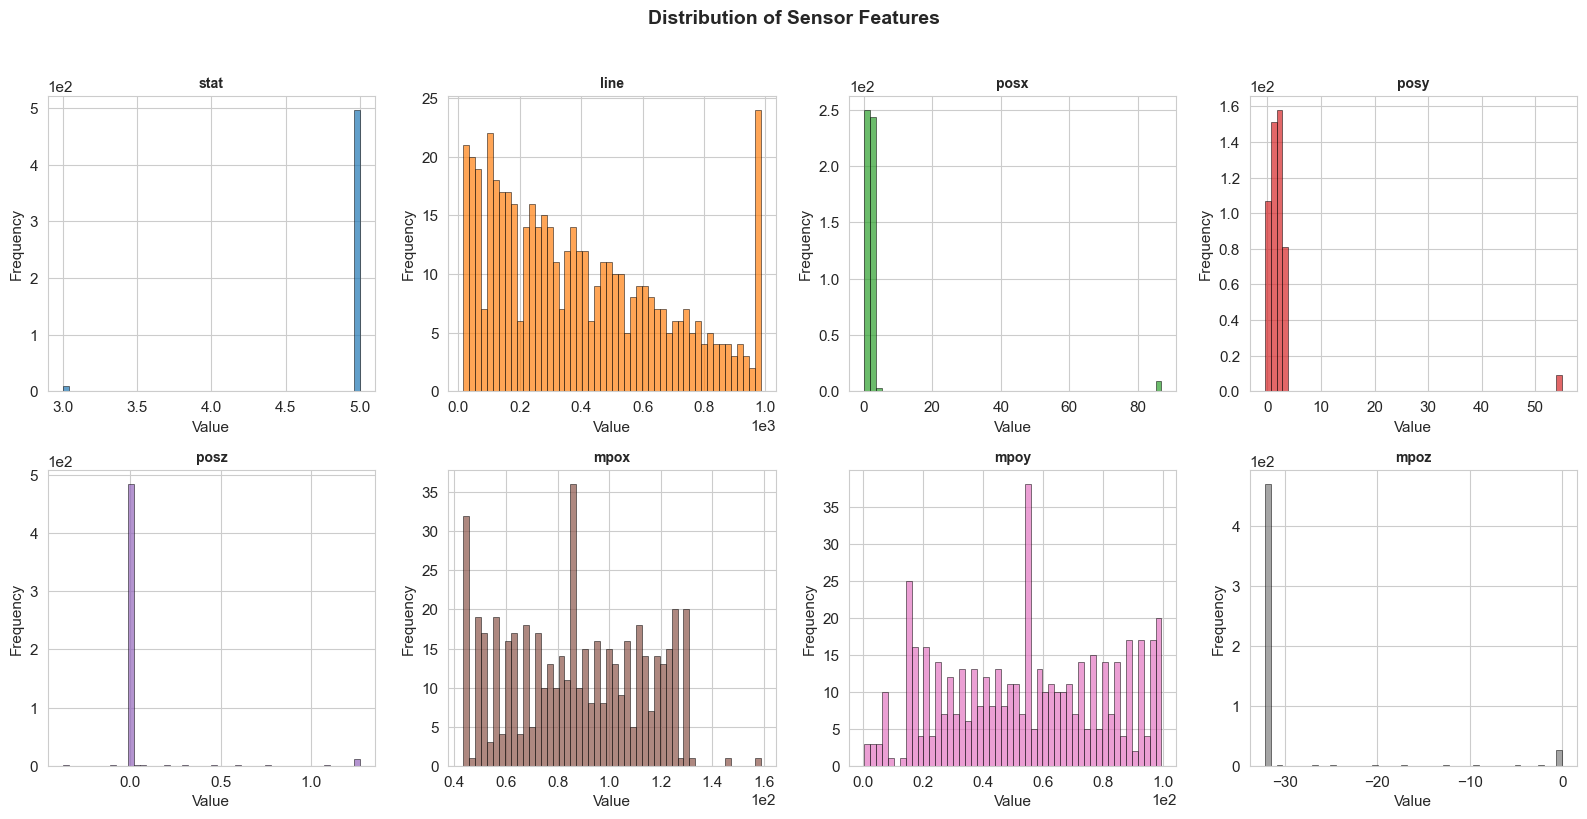

In [9]:
# Visualize sensor feature distributions
n_features = min(8, len(numeric_cols))
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, (ax, col) in enumerate(zip(axes.flat, numeric_cols[:n_features])):
    data = df_sample[col].dropna()
    ax.hist(data, bins=50, alpha=0.7, color=f'C{i}', edgecolor='black', linewidth=0.5)
    ax.set_title(col[:25], fontweight='bold', fontsize=10)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.ticklabel_format(style='sci', axis='both', scilimits=(-2,2))

plt.suptitle('Distribution of Sensor Features', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

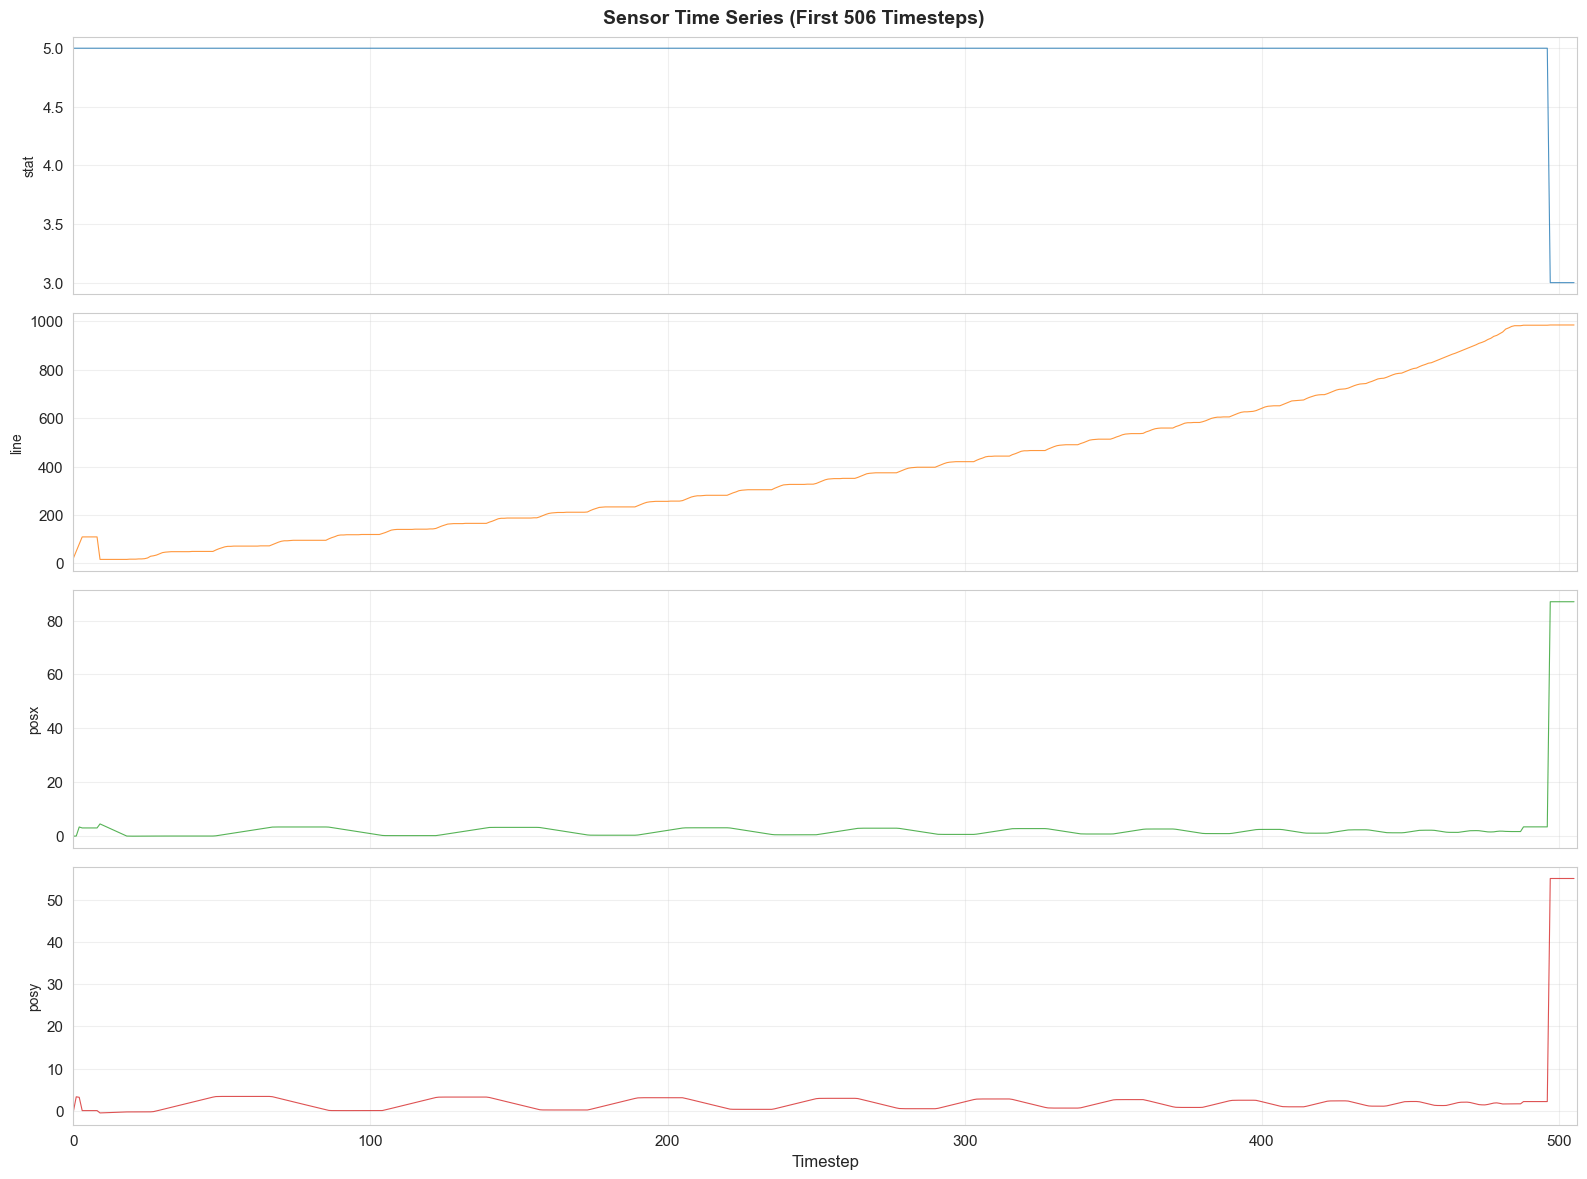

In [10]:
# Time series visualization of sensor data
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

# Plot first 1000 timesteps for clarity
n_samples = min(1000, len(df_sample))

for i, (ax, col) in enumerate(zip(axes, numeric_cols[:4])):
    ax.plot(df_sample[col].values[:n_samples], alpha=0.8, linewidth=0.8, color=f'C{i}')
    ax.set_ylabel(col[:20], fontsize=10)
    ax.grid(alpha=0.3)
    ax.set_xlim(0, n_samples)

axes[-1].set_xlabel('Timestep', fontsize=12)
plt.suptitle(f'Sensor Time Series (First {n_samples} Timesteps)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. G-code Token Analysis

Analyze the G-code tokens and their distributions.

In [14]:
# Load vocabulary file
vocab_files = list(data_dir.glob('*.json'))
print(f"Found {len(vocab_files)} vocabulary files:")
for vf in vocab_files:
    print(f"  - {vf.name}")

# Load the main vocabulary
vocab_path = data_dir / 'vocabulary_4digit_hybrid.json'
if vocab_path.exists():
    with open(vocab_path, 'r') as f:
        vocab = json.load(f)
    print(f"\nLoaded vocabulary with {len(vocab)} tokens")
else:
    # Try alternative vocab files
    vocab_path = vocab_files[0] if vocab_files else None
    if vocab_path:
        with open(vocab_path, 'r') as f:
            vocab = json.load(f)
        print(f"\nLoaded vocabulary from {vocab_path.name}: {len(vocab)} tokens")

Found 7 vocabulary files:
  - vocabulary.json
  - vocabulary_4digit_hybrid.json
  - vocab_production.json
  - vocabulary_1digit_hybrid.json
  - gcode_vocab_v2.json
  - vocabulary_2digit_fixed.json
  - gcode_vocab.json

Loaded vocabulary with 2 tokens


In [15]:
# Categorize vocabulary tokens
token_categories = {
    'G-commands': [],
    'M-commands': [],
    'X-params': [],
    'Y-params': [],
    'Z-params': [],
    'F-params': [],
    'Special': [],
    'Other': []
}

for token in vocab.keys():
    if token.startswith('<'):
        token_categories['Special'].append(token)
    elif token.startswith('G'):
        token_categories['G-commands'].append(token)
    elif token.startswith('M'):
        token_categories['M-commands'].append(token)
    elif token.startswith('X'):
        token_categories['X-params'].append(token)
    elif token.startswith('Y'):
        token_categories['Y-params'].append(token)
    elif token.startswith('Z'):
        token_categories['Z-params'].append(token)
    elif token.startswith('F'):
        token_categories['F-params'].append(token)
    else:
        token_categories['Other'].append(token)

print("Token Categories:")
print("=" * 40)
for category, tokens in token_categories.items():
    print(f"{category:15s}: {len(tokens):4d} tokens")
    if len(tokens) <= 10:
        print(f"                 {tokens}")

Token Categories:
G-commands     :    0 tokens
                 []
M-commands     :    0 tokens
                 []
X-params       :    0 tokens
                 []
Y-params       :    0 tokens
                 []
Z-params       :    0 tokens
                 []
F-params       :    0 tokens
                 []
Special        :    0 tokens
                 []
Other          :    2 tokens
                 ['config', 'vocab']


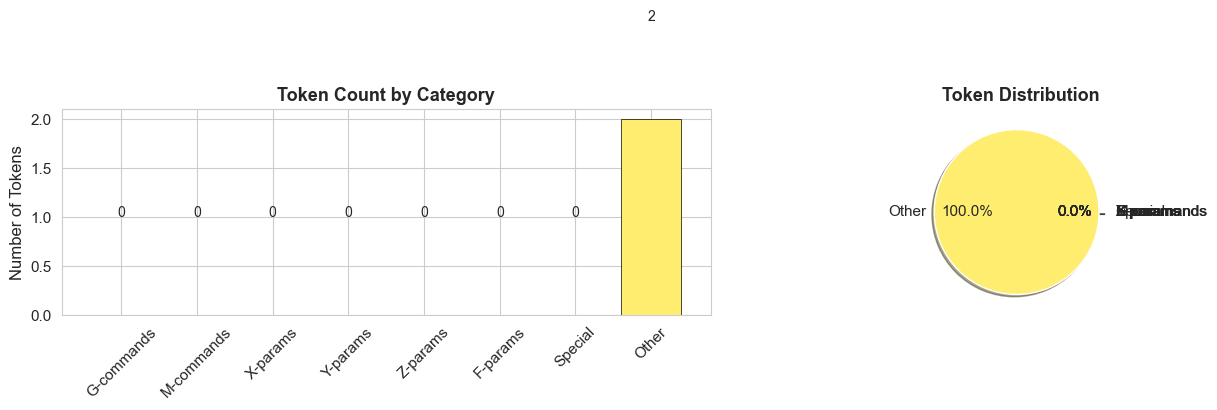

In [16]:
# Visualize token category distribution
categories = list(token_categories.keys())
counts = [len(token_categories[c]) for c in categories]
colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
bars = axes[0].bar(categories, counts, color=colors, edgecolor='black', linewidth=0.5)
axes[0].set_ylabel('Number of Tokens', fontsize=12)
axes[0].set_title('Token Count by Category', fontsize=13, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
for bar, count in zip(bars, counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 str(count), ha='center', fontsize=10)

# Pie chart
axes[1].pie(counts, labels=categories, autopct='%1.1f%%', colors=colors,
            explode=[0.05]*len(categories), shadow=True)
axes[1].set_title('Token Distribution', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Cross-Operation Analysis

Compare sensor characteristics across different operation types.

In [17]:
# Load samples from each operation type
operation_stats = {}

for op_type, files in operation_files.items():
    if len(files) == 0:
        continue
    
    # Load first file of each type
    df = pd.read_csv(files[0])
    
    # Get numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    operation_stats[op_type] = {
        'n_files': len(files),
        'n_rows': len(df),
        'n_features': len(numeric_df.columns),
        'feature_means': numeric_df.mean().to_dict(),
        'feature_stds': numeric_df.std().to_dict()
    }

print("Operation Type Statistics:")
print("=" * 60)
for op_type, stats in operation_stats.items():
    print(f"\n{op_type.upper()}:")
    print(f"  Files: {stats['n_files']}")
    print(f"  Rows (sample): {stats['n_rows']:,}")
    print(f"  Features: {stats['n_features']}")

Operation Type Statistics:

ADAPTIVE:
  Files: 45
  Rows (sample): 506
  Features: 228

FACE:
  Files: 45
  Rows (sample): 562
  Features: 228

POCKET:
  Files: 45
  Rows (sample): 615
  Features: 228

OTHER:
  Files: 1
  Rows (sample): 231
  Features: 1


In [ ]:
# Compare feature distributions across operation types
# Load one file from each operation type
operation_dfs = {}
for op_type, files in operation_files.items():
    if len(files) > 0:
        df = pd.read_csv(files[0])
        operation_dfs[op_type] = df

# Select a common feature to compare
if operation_dfs:
    common_cols = set(operation_dfs[list(operation_dfs.keys())[0]].columns)
    for df in operation_dfs.values():
        common_cols &= set(df.columns)
    
    # Get numeric common columns
    sample_df = list(operation_dfs.values())[0]
    numeric_common = [c for c in common_cols if sample_df[c].dtype in [np.float64, np.int64]]
    
    print(f"Common numeric features across all operation types: {len(numeric_common)}")

In [ ]:
# Box plot comparison across operations
if operation_dfs and numeric_common:
    feature_to_compare = numeric_common[0]  # Use first common feature
    
    # Prepare data for box plot
    plot_data = []
    labels = []
    
    for op_type, df in operation_dfs.items():
        if feature_to_compare in df.columns:
            # Sample to avoid memory issues
            values = df[feature_to_compare].dropna().values[:5000]
            plot_data.append(values)
            labels.append(op_type)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bp = ax.boxplot(plot_data, labels=labels, patch_artist=True)
    
    # Color boxes
    colors = plt.cm.Set2(np.linspace(0, 1, len(labels)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_ylabel(feature_to_compare, fontsize=12)
    ax.set_xlabel('Operation Type', fontsize=12)
    ax.set_title(f'Distribution of "{feature_to_compare}" by Operation Type', 
                 fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 5. Data Quality Assessment

Identify potential issues in the raw data.

In [ ]:
# Analyze all files for data quality
quality_report = []

for f in csv_files[:20]:  # Sample first 20 files
    df = pd.read_csv(f)
    
    # Calculate metrics
    quality_report.append({
        'file': f.name,
        'rows': len(df),
        'columns': len(df.columns),
        'missing_pct': (df.isnull().sum().sum() / df.size) * 100,
        'duplicate_rows': df.duplicated().sum(),
        'numeric_cols': len(df.select_dtypes(include=[np.number]).columns)
    })

quality_df = pd.DataFrame(quality_report)

print("Data Quality Report (Sample of 20 files):")
print("=" * 80)
print(quality_df.to_string(index=False))

print("\nSummary:")
print(f"  Average rows per file: {quality_df['rows'].mean():,.0f}")
print(f"  Total missing data: {quality_df['missing_pct'].mean():.2f}%")
print(f"  Files with duplicates: {(quality_df['duplicate_rows'] > 0).sum()}")

In [ ]:
# Check for outliers in sensor data
if len(numeric_cols) > 0:
    print("Outlier Analysis (values > 3 std from mean):")
    print("=" * 50)
    
    for col in numeric_cols[:5]:
        data = df_sample[col].dropna()
        mean, std = data.mean(), data.std()
        outliers = ((data < mean - 3*std) | (data > mean + 3*std)).sum()
        outlier_pct = (outliers / len(data)) * 100
        print(f"  {col[:30]:30s}: {outliers:5d} outliers ({outlier_pct:.2f}%)")

## 6. Correlation Analysis

Explore relationships between sensor features.

In [ ]:
# Compute correlation matrix for key features
n_corr_features = min(12, len(numeric_cols))
corr_cols = numeric_cols[:n_corr_features]

corr_matrix = df_sample[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            fmt='.2f', square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8})
plt.title('Sensor Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Find highly correlated feature pairs
print("Highly Correlated Feature Pairs (|r| > 0.8):")
print("=" * 60)

high_corr_pairs = []
for i in range(len(corr_cols)):
    for j in range(i+1, len(corr_cols)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((corr_cols[i], corr_cols[j], corr_val))

if high_corr_pairs:
    for f1, f2, r in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {f1[:25]:25s} <-> {f2[:25]:25s}: r = {r:.3f}")
else:
    print("  No highly correlated pairs found.")

## 7. Exercise: Custom Analysis

Try analyzing a specific aspect of the data yourself.

In [ ]:
# Exercise: Analyze the relationship between file size and number of rows
# Hint: Use quality_df or load more files

# Your code here:
# 1. Calculate file sizes in KB
# 2. Plot file size vs number of rows
# 3. Calculate correlation

file_sizes = [(f.stat().st_size / 1024, len(pd.read_csv(f))) for f in csv_files[:10]]
sizes, rows = zip(*file_sizes)

plt.figure(figsize=(10, 6))
plt.scatter(sizes, rows, alpha=0.7, s=100)
plt.xlabel('File Size (KB)', fontsize=12)
plt.ylabel('Number of Rows', fontsize=12)
plt.title('File Size vs Row Count', fontsize=13, fontweight='bold')
plt.grid(alpha=0.3)

# Add correlation
r = np.corrcoef(sizes, rows)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {r:.3f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))
plt.tight_layout()
plt.show()

## Summary

In this notebook, you learned:
- **Data Structure**: 145 CSV files with sensor readings and aligned G-code
- **Operation Types**: Face, Pocket, Adaptive, and Damaged operations
- **Vocabulary**: Token categories and distributions
- **Data Quality**: Missing values, outliers, and correlations
- **Feature Analysis**: Distribution and time series characteristics

## Key Findings
1. Dataset is well-structured with aligned sensor + G-code data
2. Multiple operation types provide diverse training examples
3. Some features are highly correlated (potential for dimensionality reduction)
4. Class imbalance exists in G-code token distributions

## Next Steps
Continue to **01_getting_started.ipynb** for project overview, or **02_data_preprocessing.ipynb** to prepare data for training.